# Face Recognition Model Development and Testing using the LFW Dataset

# 0. Index
1. Preparation
   
   1.1. Google Mount
   
   1.2. Import Python Packages

2. Data
  
  2.1. Face Detection and Preprocessing

  2.2. Triplet Data

3. Face Recognition Training

  3.1. Triplet Loss

  3.2. Design and Training Process for a Deep Learning Model

4. Testing with the Pre-trained Model

  4.1. Embedding Extraction and Identity Matching Functions

  4.2. Testing with Sample Images



# 1. Preparation

## 1.1 Google Mount

구글 Colab을 사용할 경우, 드라이브 마운트 후 적절한 작업 경로를 지정해 줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2. Import Python Packages

In [ ]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# 2. Data

## 2.1. Face Detection and Preprocessing

FaceNet의 [MTCNN(Multi-task Cascaded Convolutional Neural Network)](https://arxiv.org/pdf/1604.02878)을 사용하여 이미지에서 얼굴을 검출하고, 정렬(alignment) 및 자르기(cropping)를 통해 얼굴 이미지를 전처리합니다.

facenet-pytorch 설치

MTCNN (FaceNet용) GitHub: [facenet-pytorch MTCNN](https://github.com/timesler/facenet-pytorch#mtcnn)

In [ ]:
! pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from facenet_pytorch import MTCNN

# Initialize MTCNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'

mtcnn = MTCNN(keep_all=True, post_process=False, device=device)

def preprocess(img, image_size=(160, 160)):
    """
    Preprocess an image: detect, align, and crop faces.

    Parameters:
        img (numpy.ndarray): Input image in RGB format.
        image_size (tuple): Desired output image size (height, width).

    Returns:
        List of preprocessed face images as PIL images.
    """
    img_pil = Image.fromarray(img)

    # Detect and align faces
    boxes, probs, landmarks = mtcnn.detect(img_pil, landmarks=True)

    if boxes is None:
        print("No faces detected.")
        return []

    # Sort indices based on probabilities in descending order
    sorted_indices = np.argsort(probs)[::-1]  # Sort in descending order

    # Sort boxes, probs, and landmarks based on sorted indices
    boxes = boxes[sorted_indices]
    probs = probs[sorted_indices]
    landmarks = landmarks[sorted_indices]

    preprocessed_faces = []

    # For each detected face, crop and align it
    for i, box in enumerate(boxes):
        # Extract box coordinates
        x1, y1, x2, y2 = [int(coord) for coord in box]

        # Align and crop face using landmarks
        face = img_pil.crop((x1, y1, x2, y2))
        aligned_face = mtcnn(img_pil.crop((x1, y1, x2, y2)))

        if aligned_face is None:
            continue

        aligned_face = aligned_face[0].permute(1, 2, 0).detach().cpu().numpy().astype(np.uint8)
        preprocessed_faces.append(aligned_face)

    return preprocessed_faces, boxes

전처리 과정을 거친 LFW 데이터를 지정한 새로운 폴더에 저장합니다.

In [ ]:
import glob
root_dir = "/content/drive/MyDrive/Colab/study/metacode/얼굴인식/lfw"

img_list = glob.glob(f"{root_dir}/**", recursive=True)
img_list = [p for p in img_list if p.endswith(".jpg")]

save_dir = "/content/drive/MyDrive/Colab/study/metacode/얼굴인식/my_lfw"

for img_path in tqdm(img_list):
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img_preprocessed, _ = preprocess(img)

        if len(img_preprocessed) > 0:
            save_path = img_path.replace(root_dir, save_dir)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            cv2.imwrite(save_path, cv2.cvtColor(img_preprocessed[0], cv2.COLOR_RGB2BGR))
    except:
        continue

100%|██████████| 13233/13233 [3:19:16<00:00,  1.11it/s]


전처리된 데이터를 시각적으로 확인할 수 있도록 제공합니다.

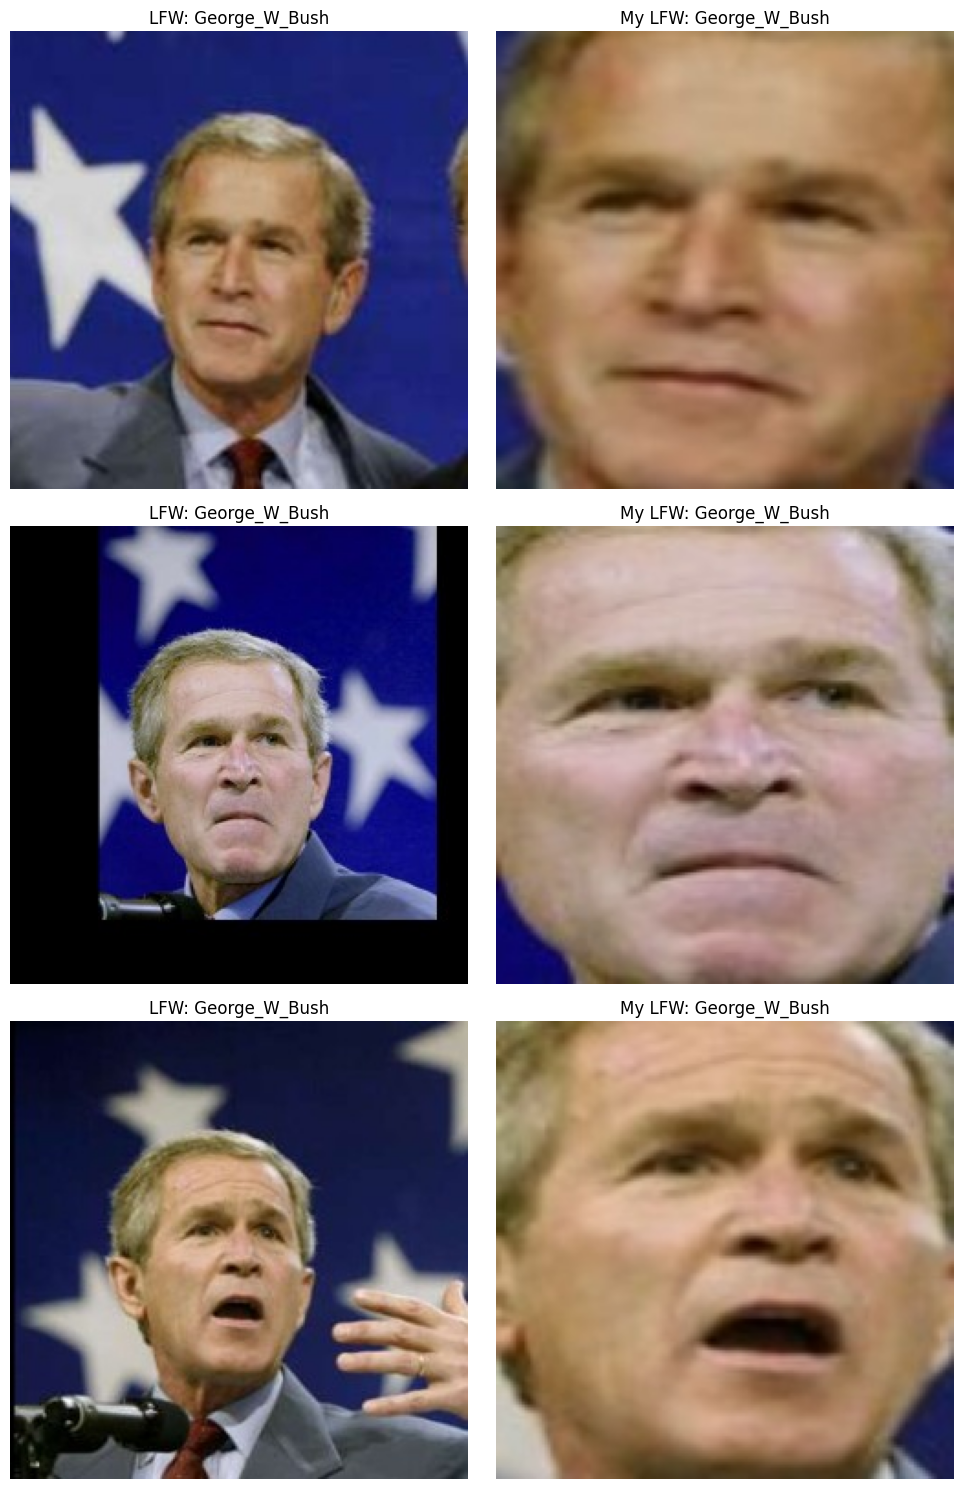

In [ ]:
# check the preprocessed dataset
def load_images_from_directory(directory, person_name, num_samples=3):
    """
    Load a specified number of images for a given person from a dataset directory.

    Parameters:
        directory (str): Path to the dataset (e.g., 'lfw' or 'my_lfw').
        person_name (str): Name of the person's folder.
        num_samples (int): Number of images to load.

    Returns:
        images (list): List of loaded images.
    """
    person_dir = os.path.join(directory, person_name)
    image_files = sorted(os.listdir(person_dir))[:num_samples]  # Sort to ensure consistency
    images = [cv2.cvtColor(cv2.imread(os.path.join(person_dir, img)), cv2.COLOR_BGR2RGB) for img in image_files]
    return images

def compare_datasets(person_name, lfw_dir='lfw', my_lfw_dir='my_lfw', num_samples=3):
    """
    Compare images for a given person from two datasets.

    Parameters:
        person_name (str): Name of the person to compare.
        lfw_dir (str): Path to the 'lfw' dataset directory.
        my_lfw_dir (str): Path to the 'my_lfw' dataset directory.
        num_samples (int): Number of images to display for each dataset.
    """
    lfw_images = load_images_from_directory(lfw_dir, person_name, num_samples)
    my_lfw_images = load_images_from_directory(my_lfw_dir, person_name, num_samples)

    # Plotting
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        # Plot LFW image
        axes[i, 0].imshow(lfw_images[i])
        axes[i, 0].set_title(f"LFW: {person_name}")
        axes[i, 0].axis("off")

        # Plot My LFW image
        axes[i, 1].imshow(my_lfw_images[i])
        axes[i, 1].set_title(f"My LFW: {person_name}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
person_name = "George_W_Bush"  # Change to the person you want to compare
compare_datasets(person_name, lfw_dir="/content/drive/MyDrive/Colab/study/metacode/얼굴인식/lfw", my_lfw_dir="/content/drive/MyDrive/Colab/study/metacode/얼굴인식/my_lfw", num_samples=3)

## 2.2. Triplet Data

Triplet Data는 주로 triplet loss를 활용하는 딥러닝 모델에서 사용하는 데이터 구성 방식으로, 한 쌍의 데이터와 또 다른 비교 데이터를 묶어 세 개의 요소로 구성됩니다.

### Triplet Data의 구성 요소

Triplet 데이터는 딥러닝에서 데이터 간의 관계를 학습하기 위해 사용되며, 세 가지 요소로 구성됩니다:

1. **Anchor (A)**  
   - 기준 데이터입니다.  
   - 예: 특정 사람의 얼굴 사진.

2. **Positive (P)**  
   - Anchor와 동일한 클래스(또는 카테고리)에 속하는 데이터.  
   - 예: Anchor와 같은 사람의 다른 얼굴 사진.

3. **Negative (N)**  
   - Anchor와 다른 클래스(또는 카테고리)에 속하는 데이터.  
   - 예: Anchor와 다른 사람의 얼굴 사진.

---

### Triplet Data의 목적

Triplet 데이터를 활용하여, 학습 과정에서 **특정 특성 공간(feature space)**에서 데이터를 다음과 같이 배치하도록 모델을 학습합니다:

- **Anchor와 Positive**는 가까운 벡터로 매핑.  
- **Anchor와 Negative**는 멀리 떨어진 벡터로 매핑.

이를 통해, 모델이 데이터 간의 유사성과 차이를 효과적으로 학습할 수 있습니다.


In [ ]:
# 1. Triplet Data Loader
class TripletLFWDataset(Dataset):
    def __init__(self, root_dir, is_train=True, num_triplets=10, triplets=None, transform=None):
        self.root_dir = root_dir
        self.is_train = is_train
        self.num_triplets = num_triplets
        self.transform = transform
        self.image_paths, self.labels = self._get_image_paths_labels()
        self.label_to_indices = self._create_label_dict()
        self.triplets = triplets

        # Generate fixed triplets if not provided
        if self.triplets is None:
            self.triplets = self._generate_triplets()

    def _get_image_paths_labels(self):
        image_paths = []
        labels = []
        label_dict = {}
        label_idx = 0

        dat_list = os.listdir(self.root_dir)
        dat_split = int(len(dat_list)*0.2)
        if self.is_train:
            dat_list = dat_list[dat_split:]
        else:
            dat_list = dat_list[:dat_split]

        for person_name in os.listdir(self.root_dir):
            person_folder = os.path.join(self.root_dir, person_name)
            if os.path.isdir(person_folder):
                for img_name in os.listdir(person_folder):
                    if img_name.endswith(".jpg"):
                        img_path = os.path.join(person_folder, img_name)
                        image_paths.append(img_path)
                        if person_name not in label_dict:
                            label_dict[person_name] = label_idx
                            label_idx += 1
                        labels.append(label_dict[person_name])

        return image_paths, labels

    def _generate_triplets(self):
        triplets = []
        for label in self.label_to_indices.keys():
            if len(self.label_to_indices[label]) < 2:
                continue

            for _ in range(self.num_triplets):
                anchor_idx = self.label_to_indices[label][0]
                positive_idx = self.label_to_indices[label][1]
                negative_label = random.choice(list(self.label_to_indices.keys()))
                while negative_label == label:
                    negative_label = random.choice(list(self.label_to_indices.keys()))
                negative_idx = random.choice(self.label_to_indices[negative_label])

                triplets.append((anchor_idx, positive_idx, negative_idx))

        return triplets

    def _create_label_dict(self):
        label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            label_to_indices[label].append(idx)
        return label_to_indices

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]

        anchor_image = Image.open(self.image_paths[anchor_idx]).convert('RGB')
        positive_image = Image.open(self.image_paths[positive_idx]).convert('RGB')
        negative_image = Image.open(self.image_paths[negative_idx]).convert('RGB')

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

전처리된 데이터를 증강(augmentation)하여 데이터의 다양성을 높이고, 이를 통해 모델의 일반화 성능을 향상시킵니다.

이후, 전처리 및 증강된 데이터를 트리플렛 데이터셋(TripletLFWDataset)으로 생성합니다.

In [ ]:
# Create dataset and dataloaders
root_dir = "/content/drive/MyDrive/Colab/study/metacode/얼굴인식/my_lfw"

input_size = 224
# 2. Data augmentation
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize to 224x224 pixels (standard input for VGG models)
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

train_dataset = TripletLFWDataset(root_dir=root_dir, is_train=True, transform=transform)
data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

전처리 및 증강이 적용된 트리플렛 데이터를 시각적으로 확인할 수 있도록 제공합니다.

In [ ]:
def denormalize(img):
    img *= [0.229, 0.224, 0.225]
    img += [0.485, 0.456, 0.406]
    img = np.uint8(img * 255)

    return img

for n, (anchor_images, pos_images, neg_images) in enumerate(data_loader):
    anchor_images = anchor_images.permute(0, 2, 3, 1)[0].numpy()
    neg_images = neg_images.permute(0, 2, 3, 1)[0].numpy()
    pos_images = pos_images.permute(0, 2, 3, 1)[0].numpy()

    anchor_images = denormalize(anchor_images)
    neg_images = denormalize(neg_images)
    pos_images = denormalize(pos_images)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(anchor_images)
    axes[0].set_title(f"Anchor")

    axes[1].imshow(pos_images)
    axes[1].set_title(f"Positive")

    axes[2].imshow(neg_images)
    axes[2].set_title(f"Negative")

    plt.show()
    plt.close()

    if n > 5:
        break


Output hidden; open in https://colab.research.google.com to view.

# 3. Face Recognition Training

* Open-set Face Recognition Model
* Triplet Loss로 학습하기

## 3.1. Triplet Loss
**Triplet Loss** 손실 함수는 임베딩 공간에서 유사한 데이터는 가까이 위치하고, 서로 다른 데이터는 멀리 위치하도록 하는 데 사용됩니다.

\begin{equation*}
L = \max \left( 0, d(A, P) - d(A, N) + \alpha \right)
\end{equation*}

### 구성 요소

- $d(A, P)$: **Anchor와 Positive 데이터 간의 거리**.  
  Anchor와 Positive는 같은 클래스(또는 카테고리)에 속하므로 거리를 최소화해야 합니다.

- $d(A, N)$: **Anchor와 Negative 데이터 간의 거리**.  
  Anchor와 Negative는 서로 다른 클래스(또는 카테고리)에 속하므로 거리를 최대화해야 합니다.

- $\alpha$ (margin):  
  Positive와 Negative 간의 거리 차이에 대한 최소 마진.  
  이 마진은 Positive와 Negative가 적절히 분리되도록 유도합니다.

---

### 손실 계산 과정

1. **Positive Distance (\(pos\_distance\))**  
   $d(A, P) = ||A - P||^2$
   Anchor와 Positive 데이터 간의 쌍별 거리를 계산합니다.

2. **Negative Distance (\(neg\_distance\))**  
   $d(A, N) = ||A - N||^2$
   Anchor와 Negative 데이터 간의 쌍별 거리를 계산합니다.

3. **손실 값 계산**  
   $L = \max \left( 0, pos\_distance - neg\_distance + margin \right)$  
   Positive와 Negative 거리 차이에 마진을 더한 값을 계산하고, 손실이 음수가 되지 않도록 $\max(0, \cdot)$를 적용합니다.

작업 경로 설정

In [ ]:
cd /content/drive/MyDrive/Colab/study/metacode/얼굴인식

/content/drive/MyDrive/Colab/study/metacode/얼굴인식


In [ ]:
from torch.nn.functional import pairwise_distance
import torch.nn as nn

# 3. Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = pairwise_distance(anchor, positive)
        neg_distance = pairwise_distance(anchor, negative)
        loss = torch.relu(pos_distance - neg_distance + self.margin)
        return loss.mean()

## 3.2. Design and Training Process for a Deep Learning Model



In [ ]:
import torchvision.models as models
import torch.optim as optim
from IPython.display import clear_output
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

criterion = TripletLoss(margin=1.0)

# 3. Training Loop
def train(model, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    running_loss = 0.0

    for batch_idx, (anchor, positive, negative) in enumerate(tqdm(train_loader,  desc=f"Training Epoch {epoch+1}")):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        # Forward pass
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = criterion(anchor_out, positive_out, negative_out)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Track loss and accuracy
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Train Loss: {epoch_loss:.4f}")

    # save torch model
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, "last_ckpt_preprocess.pt")

    return epoch_loss

# 4. Validation Loop
def validate(model, val_loader, criterion, epoch):
    model.eval()
    distances = []
    labels = []

    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in enumerate(tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")):
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            # Compute embeddings
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            # Compute distances (pairwise for anchor-positive and anchor-negative)
            pos_dist = pairwise_distance(anchor_out, positive_out).cpu().numpy()
            neg_dist = pairwise_distance(anchor_out, negative_out).cpu().numpy()

            # Collect distances and labels
            distances.extend(np.concatenate((pos_dist, neg_dist)))
            labels.extend(np.concatenate((np.ones(len(pos_dist)), np.zeros(len(neg_dist)))))

    # Convert to numpy arrays for metrics
    distances = np.array(distances)
    labels = np.array(labels)

    # Calculate predictions based on threshold
    preds = (distances < threshold).astype(int)

    # Metrics
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    roc_auc = roc_auc_score(labels, distances)  # Note: Lower distances indicate positives

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    return precision, recall, f1, roc_auc

def run_training(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
  # Example of training and validation over epochs
  train_losses = []
  val_precision_scores = []
  val_recall_scores = []
  val_f1_scores = []
  val_roc_auc_scores = []

  start_epoch = 0

  if False:
    # Continuing Training
    checkpoint = torch.load("last_ckpt_preprocess.pt", map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from next epoch
    print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")

  for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Training and validation steps
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, epoch)
    precision, recall, f1, roc_auc = validate(model, val_loader, criterion, epoch)

    # Save logs
    train_losses.append(train_loss)
    val_precision_scores.append(precision)
    val_recall_scores.append(recall)
    val_f1_scores.append(f1)
    val_roc_auc_scores.append(roc_auc)

    # Clear the output and plot the updated metrics
    clear_output(wait=True)

    # Plot training and validation loss and accuracy
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 5, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    #plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot Precision
    plt.subplot(1, 5, 2)
    plt.plot(range(1, epoch + 2), val_precision_scores, label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Validation: Precision')
    plt.legend()

    # Plot Precision
    plt.subplot(1, 5, 3)
    plt.plot(range(1, epoch + 2), val_recall_scores, label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Validation: Recall')
    plt.legend()

    # Plot Precision
    plt.subplot(1, 5, 4)
    plt.plot(range(1, epoch + 2), val_f1_scores, label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.title('Validation: F1')
    plt.legend()

    # Plot Precision
    plt.subplot(1, 5, 5)
    plt.plot(range(1, epoch + 2), val_roc_auc_scores, label='Validation ROC-AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.title('Validation: ROC-AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

  print("======================")
  print(" Training   Loss: %.4f" % train_losses[-1])
  print(" Validation Precision : %.4f" % val_precision_scores[-1])
  print(" Validation Recall : %.4f" % val_recall_scores[-1])
  print(" Validation F1 : %.4f" % val_f1_scores[-1])
  print(" Validation ROC-AUC : %.4f" % val_roc_auc_scores[-1])

- torchvision.models에서 제공하는 ResNet50 사전 학습 모델을 기반으로 합니다.

- ResNet50의 마지막 Fully Connected (FC) 레이어를 수정하여 출력 크기를 embedding_size=128로 설정합니다.

In [ ]:
import torch.nn.functional as F

class FaceResNet18(nn.Module):
    def __init__(self, embedding_size=128):
        super(FaceResNet18, self).__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, embedding_size)

    def forward(self, x):
        embeddings = self.base_model(x)

        # Normalize the embeddings to have unit norm
        return F.normalize(embeddings, p=2, dim=1)


Training

- [ ] **TODO**: Hyperparameter tuning to be adjusted later.

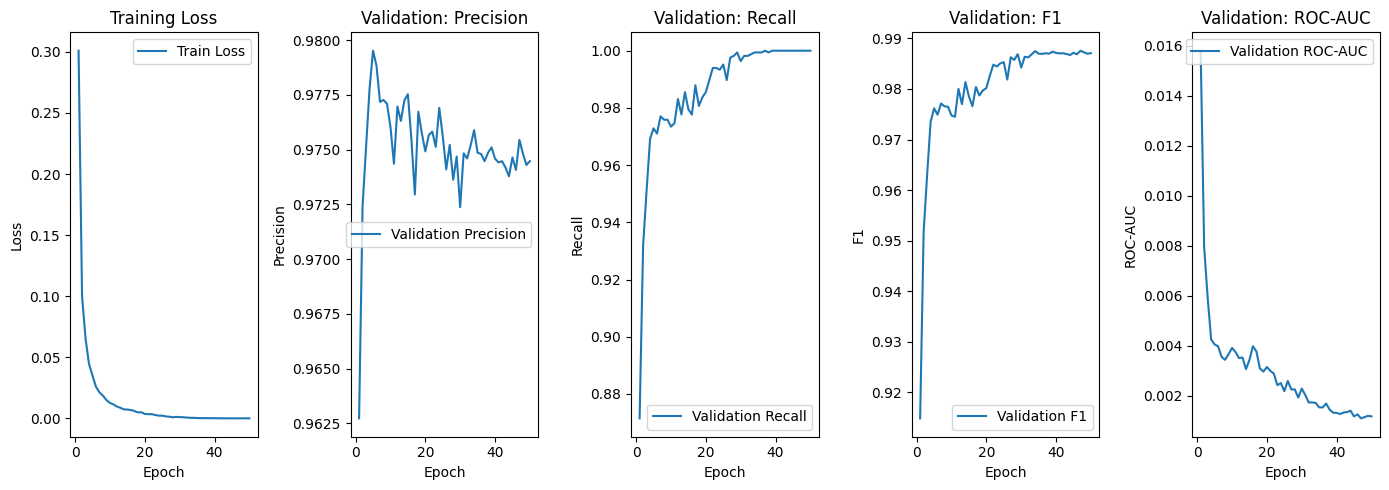

 Training   Loss: 0.0000
 Validation Precision : 0.9745
 Validation Recall : 1.0000
 Validation F1 : 0.9871
 Validation ROC-AUC : 0.0012


FaceResNet18(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:
lr = 0.0001
weight_decay=0.0
num_epochs = 50
batch_size = 64
threshold = 0.5
input_size = 112

# Load Model
embedding_size = 128
model = FaceResNet18(embedding_size)

model.to(device)

# Data Loader
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.0, hue=0.0),  # Adjust brightness and contrast
    transforms.Resize((input_size, input_size)),  # randomly crop the image
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize to 224x224 pixels (standard input for VGG models)
    transforms.ToTensor(),  # Convert to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

train_dataset = TripletLFWDataset(root_dir=root_dir, is_train=True, transform=transform)
valid_dataset = TripletLFWDataset(root_dir=root_dir, is_train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader) * num_epochs, eta_min=0)

# Start Training
run_training(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)

model.eval()

# 4. Testing with the Pre-trained Model

위에서 저장한 학습 모델이 있다면 이를 불러와 사용할 수 있습니다.

In [78]:
cd /content/drive/MyDrive/Colab/study/metacode/얼굴인식

/content/drive/MyDrive/Colab/study/metacode/얼굴인식


In [80]:
import torch.nn.functional as F

class FaceResNet18(nn.Module):
    def __init__(self, embedding_size=128):
        super(FaceResNet18, self).__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, embedding_size)

    def forward(self, x):
        embeddings = self.base_model(x)

        # Normalize the embeddings to have unit norm
        return F.normalize(embeddings, p=2, dim=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Model
embedding_size = 128
model = FaceResNet18(embedding_size)

model.to(device)

# Load pretrained weights
checkpoint = torch.load("last_ckpt_preprocess.pt", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

FaceResNet18(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

## 4.1. Embedding Extraction and Identity Matching Functions

이미지에서 쿼리 임베딩(query embedding)을 생성한 후, 갤러리(gallery) 내 임베딩과 비교하여 가장 가까운 얼굴을 식별하는 함수입니다.

In [22]:
import torchvision.transforms.functional as TF

def get_embedding(img):
    img = Image.fromarray(img)
    img = TF.resize(img, (input_size, input_size))
    img = TF.to_tensor(img)
    img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = model(img)

    return embedding

In [23]:
# Function to vectorize distance computation
def find_closest_identity(query_embedding, gallery, threshold=1.16):
    """
    Find the closest identity in the gallery for the given query embedding.

    Parameters:
    - query_embedding: The embedding vector for the query face.
    - gallery: List of tuples (name, img, embedding) for known faces.
    - threshold: Distance threshold for identifying "unknown".

    Returns:
    - min_id: The closest identity or "unknown" if above threshold.
    - min_distance: The corresponding minimum distance.
    """
    gallery_embeddings = torch.stack([g[2] for g in gallery])  # Stack all gallery embeddings
    distances = F.pairwise_distance(query_embedding, gallery_embeddings).cpu().numpy()

    min_distance = distances.min()
    min_id = gallery[distances.argmin()][0]

    if min_distance > threshold:
        min_id = "unknown"

    return min_id, min_distance

## 4.2. Testing with Sample Images

테스트 이미지 경로 지정

In [82]:
cd /content/drive/MyDrive/Colab/study/metacode/얼굴인식/t1

/content/drive/MyDrive/Colab/study/metacode/얼굴인식/t1


### Gallery Image Preprocessing and Embedding Generation

In [93]:
# Gallery image preprocessing
faker_3 = cv2.cvtColor(cv2.imread("faker_3.JPG"), cv2.COLOR_BGR2RGB)
faker_5 = cv2.cvtColor(cv2.imread("faker_5.JPG"), cv2.COLOR_BGR2RGB)
faker_9 = cv2.cvtColor(cv2.imread("faker_9.jpg"), cv2.COLOR_BGR2RGB)
faker_10 = cv2.cvtColor(cv2.imread("faker_10.jpg"), cv2.COLOR_BGR2RGB)

faker_3_preprocessed, _ = preprocess(faker_3)
faker_5_preprocessed, _ = preprocess(faker_5)
faker_9_preprocessed, _ = preprocess(faker_9)
faker_10_preprocessed, _ = preprocess(faker_10)

embed_faker_3 = get_embedding(faker_3_preprocessed[0])
embed_faker_5 = get_embedding(faker_5_preprocessed[0])
embed_faker_9 = get_embedding(faker_9_preprocessed[0])
embed_faker_10 = get_embedding(faker_10_preprocessed[0])


# List of images and embeddings
gallery = [("faker3", faker_3, embed_faker_3),
           ("faker5", faker_5, embed_faker_5),
           ("faker9", faker_9, embed_faker_9),
           ("faker10", faker_10, embed_faker_10),
           ]

### Sample Image 1

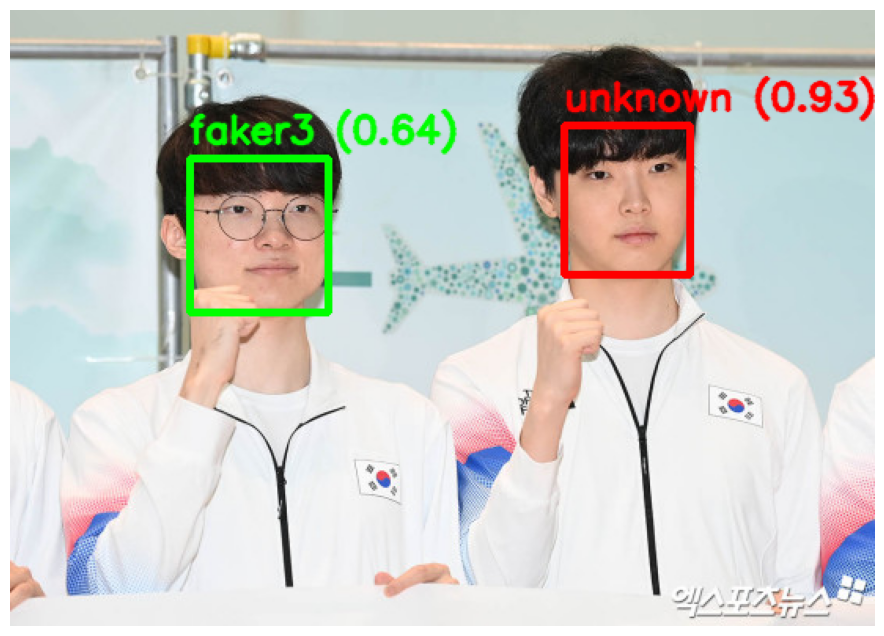

In [88]:
# @title
query_img = cv2.cvtColor(cv2.imread("faker_chovy.JPG"), cv2.COLOR_BGR2RGB)
preprocessed_imgs, boxes = preprocess(query_img)
query_embeddings = [get_embedding(img) for img in preprocessed_imgs]

threshold = 0.8

for query_embedding, bbox in zip(query_embeddings, boxes):
    min_id, min_distance = find_closest_identity(query_embedding, gallery, threshold)

    # Draw bounding box and label
    x1, y1, x2, y2 = [int(coord) for coord in bbox]
    color = (0, 255, 0) if min_id != "unknown" else (255, 0, 0)  # Green for known, Red for unknown
    query_img = cv2.rectangle(query_img, (x1, y1), (x2, y2), color, 3)
    label = f"{min_id} ({min_distance:.2f})"
    query_img = cv2.putText(query_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

# Show the annotated image
plt.figure(figsize=(12, 8))
plt.imshow(query_img)
plt.axis("off")
plt.show()

### Sample Image 2

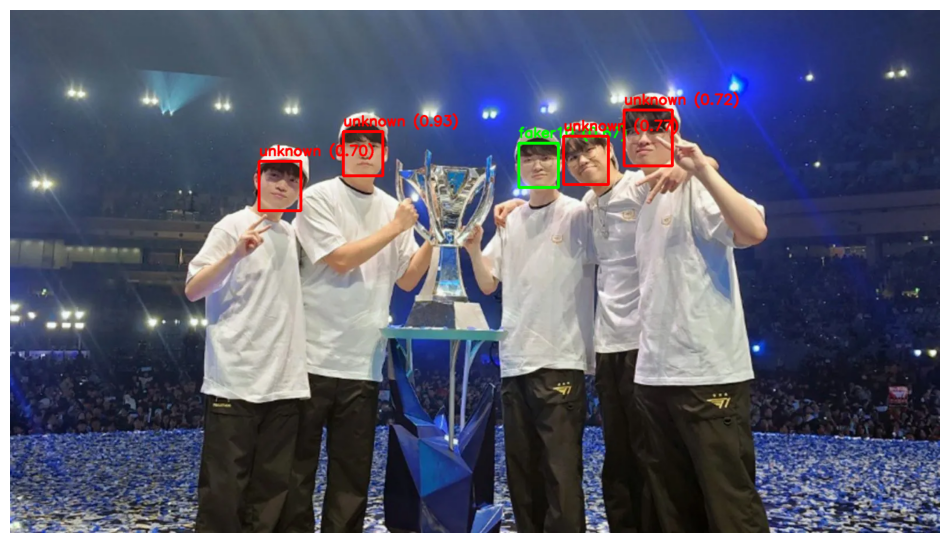

In [97]:
query_img = cv2.cvtColor(cv2.imread("faker_14.jpg"), cv2.COLOR_BGR2RGB)
preprocessed_imgs, boxes = preprocess(query_img)
query_embeddings = [get_embedding(img) for img in preprocessed_imgs]

threshold = 0.7

for query_embedding, bbox in zip(query_embeddings, boxes):
    min_id, min_distance = find_closest_identity(query_embedding, gallery, threshold)

    # Draw bounding box and label
    x1, y1, x2, y2 = [int(coord) for coord in bbox]
    color = (0, 255, 0) if min_id != "unknown" else (255, 0, 0)  # Green for known, Red for unknown
    query_img = cv2.rectangle(query_img, (x1, y1), (x2, y2), color, 3)
    label = f"{min_id} ({min_distance:.2f})"
    query_img = cv2.putText(query_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

# Show the annotated image
plt.figure(figsize=(12, 8))
plt.imshow(query_img)
plt.axis("off")
plt.show()